In [141]:
%pylab inline

import numpy as np
# initial states: [x0, y0, z0, ψ, dx0, dy0, dz0, dψ0]
x0 = [0, 0, 0, 0, 0, 0, 0, 0]
# inertia
I = 0.5
# mass
m = 0.1
# wings angle 
α = pi/6
# Do we want constains?
en_constrain = True
# simulation time
time_out = 60
tf = time_out
dt = 0.05   # Time step
test_time = linspace(0.,time_out, int(tf / dt) )  # Time interval
print(len(test_time))
# number of motors
n = 2
# position of the thrusters
d = 0.4
p = np.array([[-d, 0, 0], [d, 0, 0]]).T
# tilting angles of the propellers
#α = [-pi/2, pi/2]


# assert np.linalg.matrix_rank(A) == 3
# gravity acceleration
g = 9.8
# max force of a propeller
fM = 1.0
# minimum force of a propeller
fm = 0.01
# desired state
des_state = np.array([0, 0, 0, 0, 0, 0, 0, 0])

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
1200


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['step']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [142]:
# Fb = 0.3
# L = 0.2
# damping_w = 0.0
# damping_pos = 0.0
Kx = 0.1
Ky = 0.1 
Kz = 0.1  # K for lifting
fe = -0.01  # f effective
Kdrag = 0.5 / 2
# simulate the air pressure with Z value
K_air = 0.001
# step function for the motion of the s_blimp
def step(state, u):
    x, y, z, ψ, dx, dy, dz, dψ = state
    f1,f2 = u
    
    # accelerations 
    ax = Kx * ((f2 - f1) / m ) * sin(ψ) - Kdrag * dx 
    ay = Ky * ((f2 - f1) / m ) * cos(ψ) - Kdrag * dy 
    aψ = d * (f1 + f2) / I - Kdrag / 5 * dψ*dψ
    az = Kz * sin(α) * dψ * dψ + fe/m -Kdrag * dz 
    
    dx += ax * dt
    dy += ay * dt
    dz += az * dt
    dψ += aψ * dt
    
    x += dx * dt
    y += dy * dt
    z += dz * dt
    ψ += dψ * dt
    if z < 0:
        z = 0
    new_state = np.array([x, y, z, ψ, dx, dy, dz, dψ])
    return new_state

In [143]:
Kpxy = 0.3
Kpy = 0.1
Kpz = 0.1
Kdxy = 0.1
Kdy = 0.5
Kdz = 0.001
Kmove = 0.05
Iz = 1.0

def control(state, des_state, en_constrain):
    x, y, z, ψ, dx, dy, dz, dψ = state[0:9]
    err = des_state - state
#     err_pos = np.array([des_state[0] - state[0],des_state[1] - state[1],des_state[2] - state[2]])
    err_pos = err[0:3]
    err_vel = err[4:7]
    
    f_pos = Kpxy*(err_pos)
    
    f_vel = Kdxy*(err_vel)
    
    u = [0,0]
    # velocity P controller
#     Kpvx = 0.5
#     Kpvy = 0.5
#     Kpvz = 0.5
#     u[0] = Kpvx * err_vel[0] * (-sin(ψ)) + Kpvy * err_vel[1] * (-cos(ψ)) + Kpvz * err_vel[2]
#     u[1] = Kpvx * err_vel[0] * (sin(ψ)) + Kpvy * err_vel[1] * (cos(ψ)) + Kpvz * err_vel[2]
    #position controller
#     u[0] = Kpz * (err_pos[2] + Iz) - Kdz * err_vel[2] + Kmove * (-sin(ψ) * err_pos[0] - cos(ψ) * err_pos[1])
#     u[1] = Kpz * (err_pos[2] + Iz) - Kdz * err_vel[2] - Kmove * (-sin(ψ) * err_pos[0] - cos(ψ) * err_pos[1])
    
    #bangbang controller
    hω = 0.25
    τ = 0.3
    if 0 <= (ψ % (2*pi)) and (ψ % (2*pi)) < pi :
        u = [hω + τ, hω - τ]
    else:
        u = [hω - τ, hω + τ]
    clamp(u,fm,fM)
    return u

def clamp(vec, minimum, maximum):
    for i in range(len(vec)):
        if vec[i] < minimum:
            vec[i] = minimum
        elif vec[i] > maximum:
            vec[i] = maximum
    return vec

In [144]:
def simulate(init_state, time_out):
    length = int(time_out/dt)
    state_log = np.zeros((length, 8))
    #desstate_log = np.zeros((length, 8))
    f_log = np.zeros((length, n))
    #f_log = u_log
    #f_log = u_log2
    #f_log = u_log3
    state = init_state
    count = 0
    while count <length:
        #if count % (length//100) == 0:
        #print("{} percent".format(count//(length//100)))
        state_log[count, :] = state 
        #desstate_log[count, :] = des_state
        f = control(state, des_state, en_constrain)
        f_log[count, :] = f
        #f = f_log[count]
        state = step(state, f)
        count += 1
        
    return state_log, f_log


In [145]:
import csv
state_log, f_log = simulate(x0, time_out)
print(f_log)
# with open('state_log.csv', 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerow(["x", 'y', 'z', 'ψ', 'dx', 'dy', 'dz', 'dψ'])
#     writer.writerows(state_log)


[[0.55 0.01]
 [0.55 0.01]
 [0.55 0.01]
 ...
 [0.55 0.01]
 [0.55 0.01]
 [0.55 0.01]]


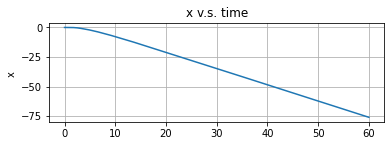

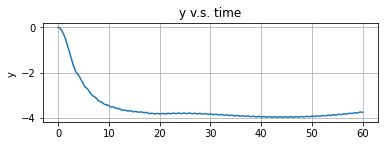

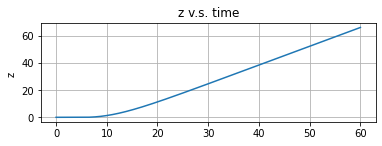

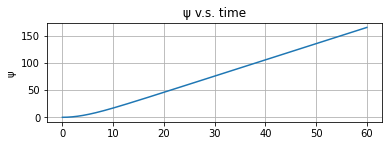

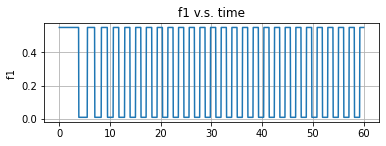

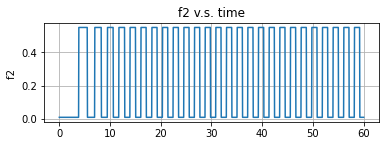

In [146]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

fig2 = plt.figure()
ax21 = fig2.add_subplot(211)
ax21.grid()
ax21.set_ylabel("x ")
ax21.set_title('x v.s. time')
# x_position, = ax21.plot(state_log[:, 0],state_log[:, 1])
x_position, = ax21.plot(test_time, state_log[:, 0])

fig2 = plt.figure()
ax21 = fig2.add_subplot(211)
ax21.grid()
ax21.set_ylabel("y ")
ax21.set_title('y v.s. time')
x_position, = ax21.plot(test_time, state_log[:, 1])

fig2 = plt.figure()
ax21 = fig2.add_subplot(211)
ax21.grid()
ax21.set_ylabel("z ")
ax21.set_title('z v.s. time')
x_position, = ax21.plot(test_time, state_log[:, 2])

fig2 = plt.figure()
ax21 = fig2.add_subplot(211)
ax21.grid()
ax21.set_ylabel("ψ ")
ax21.set_title('ψ v.s. time')
# x_position, = ax21.plot(test_time, state_log[:, 3]% (2*pi))
x_position, = ax21.plot(test_time, state_log[:, 3])

fig2 = plt.figure()
ax21 = fig2.add_subplot(211)
ax21.grid()
ax21.set_ylabel("f1 ")
ax21.set_title('f1 v.s. time')
x_position, = ax21.plot(test_time, f_log[:, 0])

fig2 = plt.figure()
ax21 = fig2.add_subplot(211)
ax21.grid()
ax21.set_ylabel("f2 ")
ax21.set_title('f2 v.s. time')
x_position, = ax21.plot(test_time, f_log[:, 1])


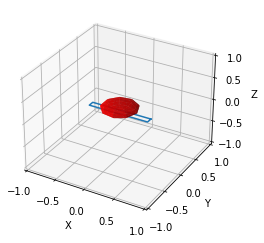

In [133]:
# sphere
def plot_globe(a,b,c,r,rotate,dense=10):
    c = c + r/3
    t1=np.linspace(0,np.pi,dense)
    t2=np.linspace(0,np.pi*2,dense)
    t1,t2=np.meshgrid(t1,t2)
    x=a+r*np.sin(t1)*np.cos(t2+rotate)
    y=b+r*np.sin(t1)*np.sin(t2+rotate)
    z=c+r*np.cos(t1)/3
    return x,y,z
# box
def box_points(w, h, z):
    points = np.zeros([5,3])
    points[0] = [ + w/2, + h/2, z]
    points[1] = [ + w/2, - h/2, z]
    points[2] = [ - w/2, - h/2, z]
    points[3] = [ - w/2, + h/2, z]
    points[4] = [ + w/2, + h/2, z]
    return points
def box_se2(x, y, z, α, ϕ, θ, ψ, u, w=1, h=.05, ax = plt.axes(projection='3d')):
    points = box_points(w, h, 0)
    # Rotation matrix
    R = [[cos(ψ), -sin(ψ), 0], 
         [sin(ψ), cos(ψ), 0],
         [0, 0, 1]]
    
    # Rotate
    points = [np.dot(R, p) for p in points]    
    points = array(points)

    # translate
    points[:,0] += x
    points[:,1] += y
    points[:,2] += z
    
    # propellers arrows length
    e1 = [1,0,0]    
    prop_x = array([sin(ψ), cos(ψ)])
    prop_y = array([sin(ψ), cos(ψ)])
    prop_z = array([0,0])
        
    # Plot propellers (start points)
    px = points[1:3,0] * 0.8
    py = points[1:3,1] * 0.8
    pz = points[1:3,2] * 0.8
    
    #draw blue arrows
    #ax.quiver(px, py, pz, 2*prop_x, 2*prop_y, 1*prop_z, color="blue")
    #draw blue box
    ax.plot(points[:,0],points[:,1], points[:,2])
    #draw red arrows with force
    #ax.quiver(px, py, pz, u*prop_x, u*prop_y, u*prop_z, color='r')
    
    a,b,c=plot_globe(a=x,b=y,c=z,r=0.3,rotate = ψ)
    
    ax.plot_surface(a,b,c,color="r",alpha=0.8)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_xlim3d((-1., 1.))
    ax.set_ylim3d((-1., 1.))
    ax.set_zlim3d((-1., 1.))

x, y, z, α, ϕ, θ, ψ  = 0,0,0, pi/6, 0, 0, 0.0
box_se2(x, y, z, α, ϕ, θ, ψ , [1,1], w=1, h=0.1)

#plot(x,y,z, 'o')
grid()

KeyboardInterrupt: 

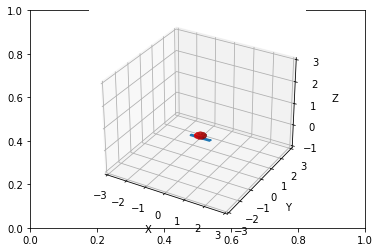

In [134]:
import matplotlib.pyplot as plt
from matplotlib import animation
from JSAnimation import IPython_display    
from IPython.display import HTML

fig,ax = plt.subplots()
ax = plt.axes(projection='3d')
def animate(t):
    ax.clear()       
    x, y, z, ψ, dx, dy, dz, dψ = state_log[t][0:9]
    
    u = f_log[t]
    #a_lift = 0.5 * sin(α) * (abs(u[0]) + abs(u[1])) - g
    # box points
    box = box_se2(x, y, z, α, ϕ, θ, ψ, u, w=1, h=0.1, ax=ax)
    #plt.plot(state_log[0],state_log[1],state_log[2], 'b')
    # Initial conditions
    #ax.plot(t, x_log[t,0],  'bo')
    ax.set_xlim((-3, 3))
    ax.set_ylim((-3, 3))
    ax.set_zlim((-1, 3))

anim = animation.FuncAnimation(fig, animate, frames=len(test_time), interval=60)
anim.save('S_blimp.gif',writer = 'pillow')
HTML(anim.to_jshtml())